# Introduction to Computer Vision - Lab 11

## Lab Task
Use your already build convolutional neural network to perform single object localization, with the scheme described in the Lecture Notes 11. 

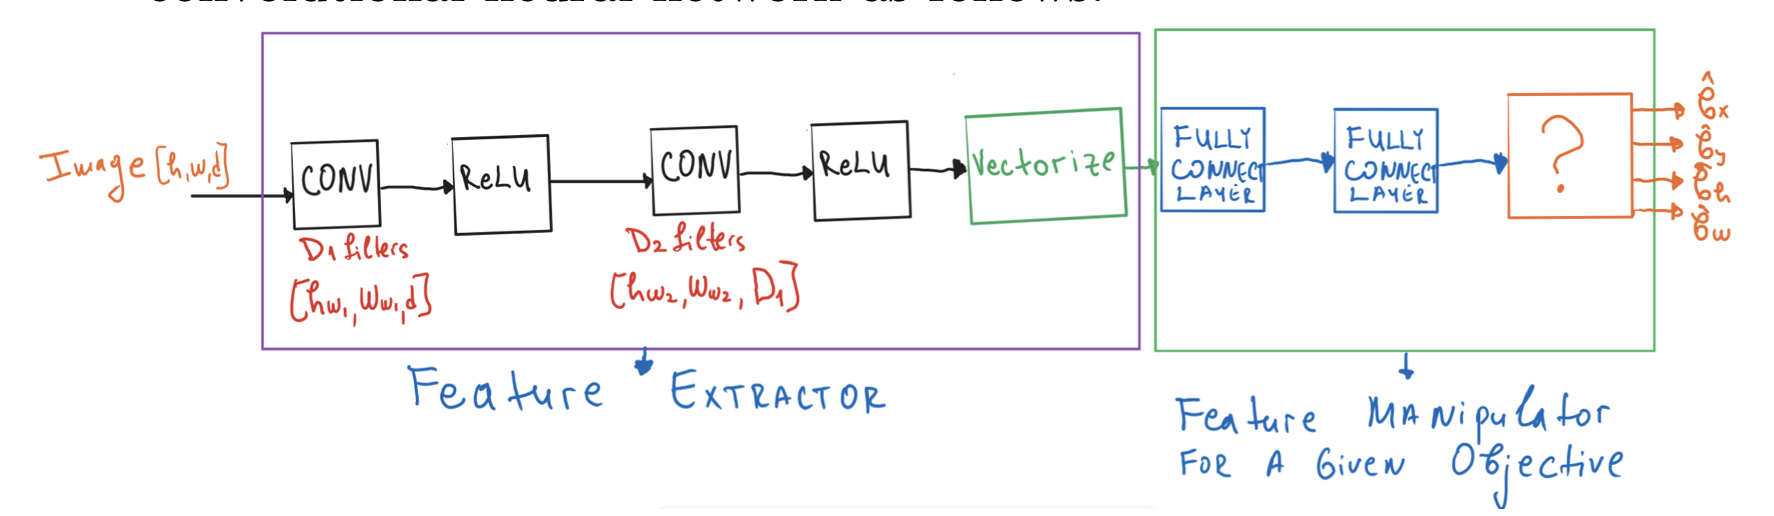

In [1]:
import numpy as np
from tqdm import tqdm

np.random.seed(0)

import requests, zipfile
from PIL import Image
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Load the suggested pikachu dataset

In [ ]:
# download zip dataset
link = 'https://www.dropbox.com/scl/fi/ha6f9n5rcae6h79dhdykb/pikachu.zip?rlkey=b1z9xqub0z4acglomt9r983q0&dl=1'
file_path = 'dataset.zip'
response = requests.get(link)

with open(file_path, 'wb') as local_file:
    local_file.write(response.content)
    
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('.')

In [2]:
# function for loading train/val images and bounding boxes locations retrieved from annotations
def load_dataset(mode='train', mode_len=900, img_size=(3, 256, 256)):
    img_path = mode + '/images/pikachu_'
    annot_path = mode + '/annotations.json'
    with open(annot_path) as file:
        annotations = json.load(file)
            
    images = []
    bound_box_locations = []
    
    for i in tqdm(range(mode_len)):
        img = np.array(Image
                       .open(img_path + str(i + 1) + '.png')
                       .convert('RGB')
                       .resize((img_size[1], img_size[2])))
        
        img = img.reshape(img_size[0], img_size[1], img_size[2])
        
        annot = annotations['data_' + str(i + 1)]
        
        loc = np.array(annot['loc'])
        
        loc_chw = np.zeros((4, ))
        loc_chw[0] = (loc[0] + loc[2]) / 2
        loc_chw[1] = (loc[1] + loc[3]) / 2
        loc_chw[2] = (loc[3] - loc[1])  # height
        loc_chw[3] = (loc[2] - loc[0])  # width
        
        images.append(img)
        bound_box_locations.append(loc_chw)

    return np.array(images), np.array(bound_box_locations)


# load train and validation datasets
train_images, train_bound_boxes = load_dataset(mode='train', mode_len=100)
val_images, val_bound_boxes = load_dataset(mode='val', mode_len=100)

print()
print('Train images shape: ', train_images.shape)  
print('Train bounding boxes coordinates shape: ', np.array(train_bound_boxes).shape, '\n')
print('Validation bounding boxes coordinates shape: ', val_images.shape)
print('Validation annotations shape: ', np.array(val_bound_boxes).shape)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 290.97it/s]


Train images shape:  (100, 3, 256, 256)
Train bounding boxes coordinates shape:  (100, 4) 

Validation bounding boxes coordinates shape:  (100, 3, 256, 256)
Validation annotations shape:  (100, 4)


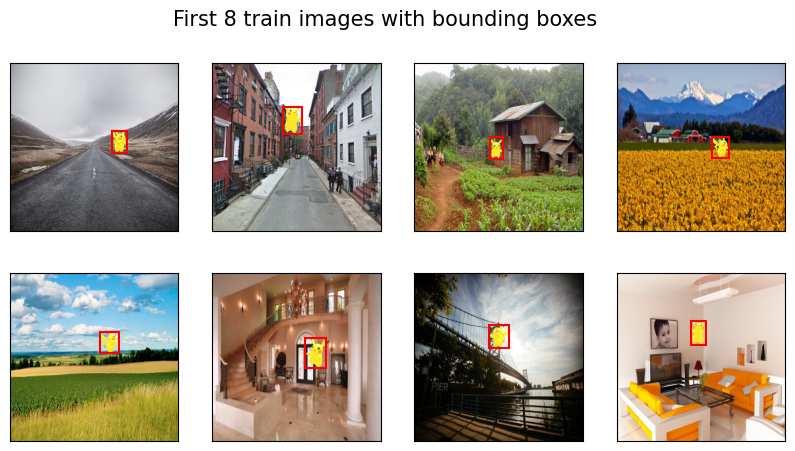

In [3]:
# plot first 8 train images with the corresponding bounding boxes
imgs = [train_images[i].reshape(256, 256, 3) for i in range(8)]
boxes = [train_bound_boxes[i] for i in range(8)]

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[i])
    rect = patches.Rectangle(xy=((boxes[i][0]-boxes[i][3]/2) * 256, 
                            (boxes[i][1] - boxes[i][2]/2) * 256), 
                            width=boxes[i][3] * 256, 
                            height=boxes[i][2] * 256, 
                            linewidth=1.5, 
                            edgecolor='r',
                            fill=False)
    ax.add_patch(rect)
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('First 8 train images with bounding boxes', fontsize=15)
plt.show()


## Image feature extractor

Here I will use already build CNN from the previous labs for single object localization.

### Convolutional Layer

In [4]:
# Class representing the Convolutional Node with padding added
class ConvNode:

    def __init__(self, padding):
        self.Zk_prev = None # the previous feature map
        self.Wk = None # the filter
        self.padding = padding # padding size

    def forward(self, Zk_prev, Wk):
        # Forward propagation
        self.Zk_prev = Zk_prev
        self.Wk = Wk

        # Apply convolution operation
        depth, h, w = self.Zk_prev.shape
        _, hw, ww = self.Wk.shape
        
        # Apply padding to the input feature map
        if self.padding > 0:
            self.Zk_prev = np.pad(self.Zk_prev, ((0, 0), 
                                                (self.padding, self.padding), 
                                                (self.padding, self.padding)), 
                                mode='constant')
        
        Zk_h = h + 2 * self.padding - hw + 1
        Zk_w = w + 2 * self.padding - ww + 1

        Zk = np.zeros((Zk_h, Zk_w))

        for d in range(depth):
            Zk += self.convolve(self.Zk_prev[d, :, :], self.Wk[d, :, :])

        return Zk

    def backward(self, dL_dZk):
        # Bacward propagation
        dL_dWk = np.zeros_like(self.Wk)
        dL_dZk_prev = np.zeros_like(self.Zk_prev)

        # Compute gradients using formulas (5) and (9) from lecture slides
        for d_i in range(self.Wk.shape[0]):
            dL_dWk[d_i, :, :] = self.convolve(self.Zk_prev[d_i, :, :], dL_dZk)
            dL_dZk_prev[d_i, :, :] = self.convolve(self.pad(dL_dZk, self.Wk),
                                                   self.rotate(self.Wk[d_i, :, :]))
        
        # Remove padding from gradients
        if self.padding > 0:
            dL_dZk_prev = dL_dZk_prev[:, self.padding:-self.padding, self.padding:-self.padding]
            dL_dWk = dL_dWk[:, self.padding:-self.padding, self.padding:-self.padding]
            
        return dL_dWk, dL_dZk_prev

    def convolve(self, X, W):
        # Convolution operation between X and W that produces the matrix Z
        h, w = X.shape
        hw, ww = W.shape

        Z_h = h - hw + 1
        Z_w = w - ww + 1
        Z = np.zeros((Z_h, Z_w))

        for i in range(Z_h):
            for j in range(Z_w):
                Z[i, j] = np.sum(X[i:i+hw, j:j+ww] * W)

        return Z

    def rotate(self, Z):
        # Rotate the matrix Z by 180 degrees
        return np.flip(np.flip(Z, 1), 0)

    def pad(self, Z, Wk):
        # Pad the matrix Z with zeros
        return np.pad(Z, ((Wk.shape[1]-1, Wk.shape[1]-1),
                          (Wk.shape[2]-1, Wk.shape[2]-1)),
                        mode='constant')


In [5]:
# Class representing the Convolutional Layer
class ConvLayer:

    def __init__(self, D, filter_shape, Bk, padding=0):
        # D - number of filters
        self.D = D
        self.padding = padding
        
        # initialize the D filters
        self.filters = np.array([np.random.randn(*filter_shape) / 9 for _ in range(D)])
        self.conv_nodes = [ConvNode(padding) for _ in range(D)]
        self.Bk = Bk
        self.Zk = np.zeros_like(Bk)

    def forward(self, Zk_prev):
        # forward propagation
        self.Zk_prev = Zk_prev
        self.Zk = np.zeros_like(self.Bk)

        # apply convolution operation for each filter and after add bias
        for d in range(self.D):
            Zk_tilde = self.conv_nodes[d].forward(self.Zk_prev, self.filters[d])
            self.Zk[d, :, :] = Zk_tilde + self.Bk[d, :, :]

        return self.Zk

    def backward(self, dL_dZk):
        # backward propagation
        dL_dBk = dL_dZk
        
        dL_dWks = np.zeros_like(self.filters)
        dL_dZk_prev = np.zeros_like(self.Zk_prev)

        # compute gradients using formulas from lecture slides
        for d in range(self.D):
            dL_dWk, dL_dZk_prev_d = self.conv_nodes[d].backward(dL_dZk[d, :, :])
            dL_dWks[d] = dL_dWk
            dL_dZk_prev += dL_dZk_prev_d

        return dL_dBk, dL_dWks, dL_dZk_prev

### Activation functions

In [6]:
# Class representing the ReLU node (from the previous labs)
class ReLU:

    def __init__(self):
        self.x = None  # input values

    def forward(self, x):
        # calculate output of relu function
        self.x = x
        return np.maximum(0, self.x)

    def backward(self, loss_grad):
        # compute gradients with respect to the input values
        relu_der = np.where(self.x < 0, 0, 1) # local gradient of relu
        grad = relu_der * loss_grad
        return grad

In [8]:
# Class representing the Sigmoid node
class Sigmoid:
    
    def __init__(self):
        self.z = None
    
    def forward(self, x):
        # calculate output of sigmoid function
        self.z = 1 / (1 + np.exp(-x))
        return self.z
    
    def backward(self, loss_grad):
        # compute gradients with respect to the input values
        sigmoid_grad = loss_grad * self.z * (1 - self.z)
        return sigmoid_grad

### Vectorization Layer

In [9]:
# Class representing the Vectorization Layer
class VectorizationLayer:
    def __init__(self):
        self.input_shape = None

    def forward(self, X):
        self.input_shape = X.shape
        return X.reshape(-1, 1)

    def backward(self, dL_dZ):
        return dL_dZ.reshape(self.input_shape)

### Fully-Connected Layer

In [10]:
# Matrix multiplication node (from the previous labs)
class MulNode:

    def __init__(self):
        self.w = None  # input matrix W
        self.x = None  # input values x
        self.grad = None  # gradient with respect to W (result of backward propagation)

    def forward(self, w, x):
        # calculate output of multiplication W*X
        self.w, self.x = w, x
        return np.matmul(self.w, self.x)

    def backward(self, dL_dz):
        # compute gradient with respect to W
        dz_dw = self.x.reshape((1, self.x.shape[0]))
        self.grad = np.matmul(dL_dz, dz_dw)
        return self.grad

In [11]:
# Class representing the Fully Connected Layer
class FullyConnectedLayer:

    def __init__(self):
        self.mult = MulNode()

    def forward(self, X, W, b):
        # forward propagation
        self.W = W
        Z = self.mult.forward(self.W, X)
        return Z + b

    def backward(self, dL_dZ):
        # backward propagation
        dL_db = dL_dZ
        dL_dW = self.mult.backward(dL_dZ)
        dL_dX = np.dot(np.transpose(self.W), dL_dZ)
        return dL_db, dL_dW, dL_dX

### Define model architecture

In [12]:
# Class representing the Convolutional Neural Network for Pikachu Object Localization
class CNN_ObjectLocalization:
    
    def __init__(self):
        self.b1 = np.zeros((1, 252, 252))
        self.b2 = np.zeros((1, 248, 248))
        self.b3 = np.zeros((4, 1))
        self.W3 = np.random.uniform(-1, 1, (4, 248*248))
        self.conv_layer1 = ConvLayer(D=1, filter_shape=(3, 5, 5), Bk=self.b1)
        self.relu1 = ReLU()
        self.conv_layer2 = ConvLayer(D=1, filter_shape=(1, 5, 5), Bk=self.b2)
        self.relu2 = ReLU()
        self.vectorize = VectorizationLayer()
        self.fc1 = FullyConnectedLayer()
        self.sigmoid = Sigmoid()

    def forward(self, X):
        # forward propagation
        Z = self.conv_layer1.forward(X)
        Z = self.relu1.forward(Z)
        Z = self.conv_layer2.forward(Z)
        Z = self.relu2.forward(Z)
        Z = self.vectorize.forward(Z)
        Z = self.fc1.forward(Z, self.W3, self.b3)
        Z = self.sigmoid.forward(Z)
        return Z

    def backward(self, dL_dZ):
        # backward propagation
        dL_dz = self.sigmoid.backward(dL_dZ)
        dL_db3, dL_dW3, dL_dz = self.fc1.backward(dL_dz)
        dL_dz = self.vectorize.backward(dL_dz)
        dL_dz = self.relu2.backward(dL_dz)
        dL_dB2, dL_dW2, dL_dz = self.conv_layer2.backward(dL_dz)
        dL_dz = self.relu1.backward(dL_dz)
        dL_dB1, dL_dW1, dL_dZ = self.conv_layer1.backward(dL_dz)
        return dL_dB1, dL_dW1[0], dL_dB2, dL_dW2[0], dL_db3, dL_dW3

In [15]:
# check the forward propagation for the first image in the train set
model = CNN_ObjectLocalization()
model.forward(train_images[0])

array([[0.39815699],
       [0.52917104],
       [0.48637872],
       [0.45692261]])

In [16]:
# check the shapes of output of the backward propagation
loss = np.array([1, 0, 0, 0]).reshape(-1, 1)
dL_dB1, dL_dW11, dL_dB2, dL_dW2, dL_db3, dL_dW3 = model.backward(loss)
dL_dB1.shape, dL_dW11.shape, dL_dB2.shape, dL_dW2.shape, dL_db3.shape, dL_dW3.shape

((1, 252, 252), (3, 5, 5), (1, 248, 248), (1, 5, 5), (4, 1), (4, 61504))

### Perform the Mini-Batch Gradient Descent

In [ ]:
# define the batch size
batch_size = 64

# define the number of epochs
num_epochs = 10

# define the learning rate
eta = 0.01

# define the number of batches
num_batches = len(train_images) // batch_size

# perform the Mini-Batch Gradient Descent

# loop over the epochs
for epoch in tqdm(range(num_epochs)):

    # initialize the gradients
    dL_db1 = np.zeros_like(model.b1)
    dL_db2 = np.zeros_like(model.b2)
    dL_db3 = np.zeros_like(model.b3)
    # dL_db4 = np.zeros_like(model.b4)
    dL_dW1 = np.zeros_like(model.conv_layer1.filters[0])
    dL_dW2 = np.zeros_like(model.conv_layer2.filters[0])
    dL_dW3 = np.zeros_like(model.W3)
    # dL_dW4 = np.zeros_like(model.W4)

    # loop over the batches
    for batch in range(1, num_batches + 1):
        # get the batch data
        batch_x = train_images[(batch-1)*batch_size:batch*batch_size]
        batch_y = train_bound_boxes[(batch-1)*batch_size:batch*batch_size]
        
        # loop over the batch data
        for x, y in zip(batch_x, batch_y):

            # perform forward propagation
            y_hat = model.forward(x).reshape(-1)
            
            # compute the loss
            l = (y[0] - y_hat[0])**2 + (y[1] - y_hat[1])**2 + (y[2] - y_hat[2])**2 + (y[3] - y_hat[3])**2
            print(l, y_hat)

            # compute the gradient of the loss 
            grad_l = np.array([2 * (y_hat[0] - y[0]),
                               2 * (y_hat[1] - y[1]),
                               2 * (y_hat[2] - y[2]),
                               2 * (y_hat[3] - y[3])]).reshape(-1, 1)

            # compute the gradients
            dL_db1_i, dL_dW1_i, dL_db2_i, dL_dW2_i, dL_db3_i, dL_dW3_i = model.backward(grad_l)
            dL_db1 += dL_db1_i
            dL_db2 += dL_db2_i
            dL_db3 += dL_db3_i
            # dL_db4 += dL_db4_i
            dL_dW1 += dL_dW1_i
            dL_dW2 += dL_dW2_i
            dL_dW3 += dL_dW3_i
            # dL_dW4 += dL_dW4_i


       # update the weights and biases
        model.b1 -= eta * dL_db1 / batch_size
        model.conv_layer1.filters[0] -= eta * dL_dW1 / batch_size
        model.b2 -= eta * dL_db2 / batch_size
        model.conv_layer2.filters[0] -= eta * dL_dW2 / batch_size
        model.b3 -= eta * dL_db3 / batch_size
        model.W3 -= eta * dL_dW3 / batch_size
        # model.b4 -= eta * dL_db4 / batch_size
        # model.W4 -= eta * dL_dW4 / batch_size


### Model performance

In [21]:
 # Compute the IoU metric for the given ground truth y and predicted bounding boxes y_hat
def compute_iou_metric(y, y_hat):
    x_A = max((y[0] - y[3] / 2), (y_hat[0] - y_hat[3] / 2))
    y_A = max((y[1] - y[2] / 2), (y_hat[1] - y_hat[2] / 2))
    x_B = min((y[0] + y[3] / 2), (y_hat[0] + y_hat[3] / 2))
    y_B = min((y[1] + y[2] / 2), (y_hat[1] + y_hat[2] / 2))

    box_y_area = y[2] * y[3]
    box_y_hat_area = y_hat[2] * y_hat[3]
    
    area_inter = max(0, x_B - x_A) * max(0, y_B - y_A)
    area_union = box_y_area + box_y_hat_area - area_inter

    return area_inter / area_union


# Evaluate the model on validation set
iou_sum = 0

for x, y in tqdm(zip(val_images, val_bound_boxes), total=len(val_images)):
    # perform forward propagation and compute the IoU 
    y_hat = model.forward(x).reshape(-1)
    iou_sum += compute_iou_metric(y, y_hat)


# calculate the mean IoU score for the validation set
mean_iou = iou_sum / len(val_images)
print(f"Mean IOU score: {mean_iou:.4f}")

100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

Mean IOU score: 0.1458


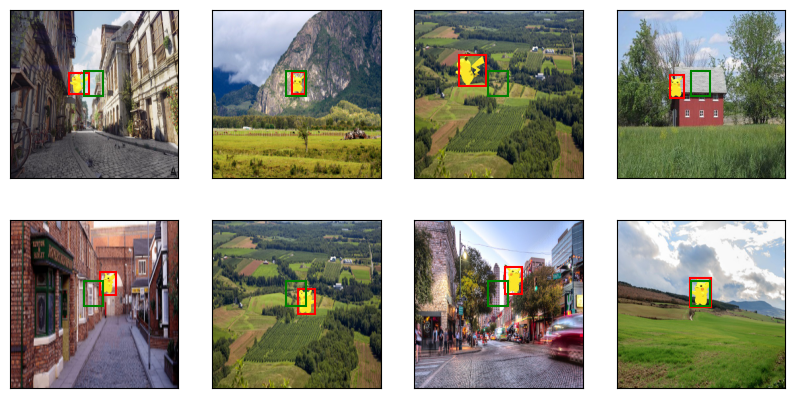

In [30]:
# plot some 8 validation images with the corresponding bounding boxes
range_val = range(6, 14)
imgs = [val_images[i].reshape(256, 256, 3) for i in range_val]
boxes = [val_bound_boxes[i] for i in range_val]

pred_boxes = [model.forward(val_images[i]).reshape(-1) for i in range_val]

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[i])
    true_rect = patches.Rectangle(xy=((boxes[i][0]-boxes[i][3]/2) * 256, 
                            (boxes[i][1] - boxes[i][2]/2) * 256), 
                            width=boxes[i][3] * 256, 
                            height=boxes[i][2] * 256, 
                            linewidth=1.5, 
                            edgecolor='r',
                            fill=False)
    ax.add_patch(true_rect)
    
    pred_rect = patches.Rectangle(xy=((pred_boxes[i][0]-pred_boxes[i][3]/2) * 256, 
                                (pred_boxes[i][1] - pred_boxes[i][2]/2) * 256), 
                                width=pred_boxes[i][3] * 256, 
                                height=pred_boxes[i][2] * 256, 
                                linewidth=1.5, 
                                edgecolor='g',
                                fill=False)
    ax.add_patch(pred_rect)
        
    ax.set_xticks([])
    ax.set_yticks([])
